## 1. (Computation) Sparse Matrices and Efficiency

When we discretize boundary value problems as we did in the previous homework, we often get sparse matrices.  For a the center difference quotient in 1D, the only non-zero entries are on the diagonal, the subdiagonal, and the superdiagonal which is $3n-2$ non-zero entries in an $n \times n$ matrix.  

Create the system $A u = f$ with
```
import numpy as np
import scipy.sparse as sparse
e = np.ones(n)
Asp = (n + 1)**2 * sparse.diags([-e, 2*e, -e], offsets=[-1, 0, 1], shape=(n, n),format='csr')
Afull = Asp.toarray()
x = np.linspace(0,1,n+2)
x = x[1:-1]  # Exclude endpoints
u_exact = np.sin(2*np.pi*x) + np.sin(7*np.pi*x)
f = Asp@u_exact
```
`Asp` stores the matrix in sparse format, while `Afull` stores the matrix as a standard numpy array.  

We will compare the solve time of the system using `Asp` and a sparse solver (`spsolve` from `scipy.sparse.linalg`) with the standard solver for the full matrix using ` np.linalg.solve`.  Time the code for $n = 2000, 4000, 8000$ using both methods and make a table with your findings.


 | n    | Sparse  | Full   |
 |----  |---------|--------|
 | 2000 |  0.0000 | 0.0000 |
 | 4000 |         |        |
 |      |         |        |


What do you observe?

In [13]:
import numpy as np
import time
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve


def time_solvers(n):
    e = np.ones(n)
    Asp = (n + 1)**2 * sparse.diags([-e, 2*e, -e], offsets=[-1, 0, 1], shape=(n, n),format='csr')
    Afull = Asp.toarray()
    x = np.linspace(0,1,n+2)
    x = x[1:-1]  # Exclude endpoints
    u_exact = np.sin(2*np.pi*x) + np.sin(7*np.pi*x)
    f = Asp@u_exact
    
    # sparse solver
    start_time = time.time()
    sparse = spsolve(Asp, f)
    sparse_time = time.time() - start_time

    # full solver
    start_time = time.time()
    full = np.linalg.solve(Afull, f)
    full_time = time.time() - start_time

    return sparse_time, full_time

n = [2000, 4000, 8000]
times = [time_solvers(i) for i in n]
for i in range(len(n)):
    print(f"n = {n[i]}")
    print(f"Sparse time: {times[i][0]:.6f} s")
    print(f"Full time: {times[i][1]:.6f} s")
    print()

# I observe that the sparse solver is faster than the full solver for all n values. Also, the difference in time between the sparse and full solver increases as n increases. In other words, the sparse solver scales more efficiently with n than the full solver.



n = 2000
Sparse time: 0.000000 s
Full time: 0.103380 s

n = 4000
Sparse time: 0.001000 s
Full time: 0.743629 s

n = 8000
Sparse time: 0.001004 s
Full time: 5.424173 s



## 2. (Theory) Derivation of Conjugate Gradient

For the conjugate gradient algorithm, we will show the 
derivation of $\alpha_k$ and $\beta_k.$
1. Using the objective function $\phi(x) = \frac{1}{2} x^T A x - b^T x,$ derive the expression for $\alpha_k$ as a minimizer of 
$\phi(x_k + \alpha d_k).$  Derive the expression $\beta_k$ so that $d_{k+1} = r_{k+1} + \beta_k d_k$ satisfies $d_{k+1}^T A d_k = 0.$
2. Using Theorem 2.16 in the text, show that the expressions of $\alpha_k$ and $\beta_k$ in the previous part are equivalent to the expressions given in the algorithm listing on page 122.


### 1.
First part:
$$\phi(x) = \frac{1}{2} x^T A x - b^T x$$
$$\phi(x_k + \alpha d_k) = \frac{1}{2} (x_k + \alpha d_k)^T A (x_k + \alpha d_k) - b^T (x_k + \alpha d_k)$$
$$\phi(x_k + \alpha d_k) = \frac{1}{2} ( x_k^T A x_k + 2 \alpha x_k^T A d_k + \alpha^2 d_k^T A d_k) - b^T x_k - \alpha b^T d_k$$
$$\frac{d}{d\alpha}\phi(x_k + \alpha d_k) = x_k^T A d_k + \alpha d_k^T A d_k - b^T d_k = 0$$
$$\alpha d_k^T A d_k =  b^T d_k - x_k^T A d_k$$
$$\alpha d_k^T A d_k =  (b - A x_k)^T d_k$$
$$\text{since }r_k = b - Ax_k \text{ we have}$$
$$\alpha d_k^T A d_k =  r_k^T d_k$$
$$\boxed{\alpha_k = \frac{r_k^Td_k}{d_k^T A d_k}}$$

Second Part:
$$d_{k+1} = r_{k+1} + \beta_k d_k$$
$$d_{k+1}^T A d_k = 0$$
$$(r_{k+1} + \beta_k d_k)^T A d_k = 0$$
$$r_{k+1}^T A d_k + \beta_k d_k^T A d_k = 0$$
$$\beta_k d_k^T A d_k = -r_{k+1}^T A d_k$$
$$\boxed{\beta_k = -\frac{r_{k+1}^T A d_k}{d_k^T A d_k}}$$

### 2.
On page 122 of the textbook we are given that $\beta_k = -\frac{r_{k+1}^T r_{k+1}}{r_k^T r_k}$ and $\alpha_k = \frac{r_k^Tr_k}{d_k^T A d_k}$. This slightly differs from our derivations above, but we will show that they are equivalent.
$$d_k = r_k + \beta_{k-1}d_{k-1}$$

$$r_k^T d_k = r_k^T(r_k + \beta_{k-1}d_{k-1})$$
$$= r_k^T r_k + \beta_{k-1}r_k^T d_{k-1}$$
$$r_k^T d_{k-1} = 0$$
$$r_k^T d_k = r_k^T r_k + \beta_{k-1} \cdot 0 = r_k^T r_k$$
$$\alpha_k = \frac{r_k^Td_k}{d_k^T A d_k} = \frac{r_k^Tr_k}{d_k^T A d_k}$$

From the last part we have $\beta_k = -\frac{r_{k+1}^T A d_k}{d_k^T A d_k}$ and we wish to show that it is the same as $\beta_k = -\frac{r_{k+1}^T r_{k+1}}{r_k^T r_k}$
$$\beta_k = -\frac{r_{k+1}^T A d_k}{d_k^T A d_k}$$
$$A d_k = \frac{r_k - r_{k+1}}{\alpha_k}$$
$$\beta_k = -\frac{r_{k+1}^T [\frac{r_k - r_{k+1}}{\alpha_k}]}{d_k^T [\frac{r_k - r_{k+1}}{\alpha_k}]}$$
$$= -\frac{r_{k+1}^T (r_k - r_{k+1})}{d_k^T (r_k - r_{k+1})}$$
Numerator:
$$r_{k+1}^T (r_k - r_{k+1}) = r_{k+1}^T r_k - r_{k+1}^T r_{k+1}$$
$$r_{k+1}^T (r_k - r_{k+1}) = 0 - r_{k+1}^T r_{k+1} = -r_{k+1}^T r_{k+1} \hspace{1cm} \text{(theorem 2.16b)}$$
Denominator:
$$d_{k+1} = r_{k+1} + \beta_{k} d_k$$
$$d_k^T (r_k - r_{k+1}) = (r_k + \beta_{k-1} d_{k-1})^T (r_k - r_{k+1})$$
$$= r_k^T r_k - r_k^T r_{k+1} + \beta_{k-1} d_{k-1}^T r_k - \beta_{k-1} d_{k-1}^T r_{k+1}$$
$$ = r_k^T r_k \hspace{1cm} \text{(other terms go to 0)}$$ 
$$-\frac{r_{k+1}^T A d_k}{d_k^T A d_k} = -\frac{r_{k+1}^T r_{k+1}}{r_k^T r_k}$$


## 3. (Computation) Convergence of Conjugate Gradient

1. Implement the conjugate gradient algorithm, making a function
`cg( A, b, x0, kmax, TOL=1e-8)` that runs at most `kmax` iterations of the conjugate gradient method (see listing on page 122 of the text).


2. Run 500 iterations of conjugate gradient for the following
2D boundary value problem: 
```
import numpy as np
import scipy.sparse as sparse
n = 100
e = np.ones(n**2)
Asp = (n + 1)**2 * sparse.diags([-e, -e, 4*e, -e, -e], offsets=[-n, -1, 0, 1, n], shape=(n**2, n**2))
x = np.linspace(0,1,n+2)
x = x[1:-1]  # Exclude endpoints
xx, yy = np.meshgrid(x, x)
u_exact = np.sin(2 * np.pi * xx) * np.sin(2 * np.pi * yy) + xx * (1 - xx) * np.sin(4 * np.pi * yy)
u_exact = u_exact.ravel()  # Reshape the array to allow matrix-vector multiplication
```
Inside your `cg` function, compute the 2-norm of the error (you should modify the function to take in the exact solution to compute this).  Plot this norm as a function of the iteration number $i$ in a `semilogy` plot for the 500 iterations.


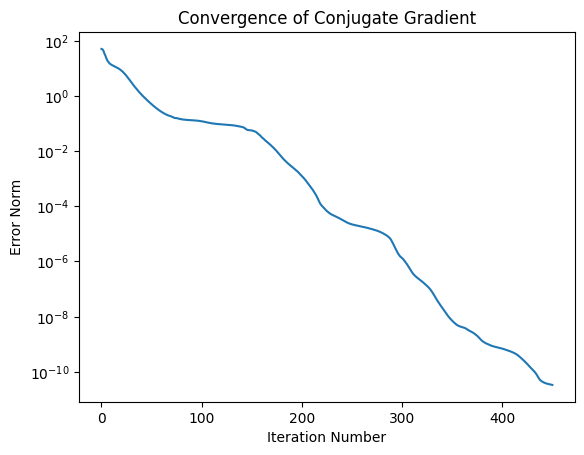

In [22]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

def cg(A, b, x0, kmax, u_exact, TOL=1e-8):
    '''Runs k iterations of conjugate gradient algorithm starting from x0 and returns xk'''
    d = b - A @ x0
    r = d
    x = x0
    error_norms = []
    for k in range(kmax):
        if np.linalg.norm(r) < TOL:
            break
        alpha = r.T @ r / (d.T @ A @ d)
        x = x + alpha * d
        old_r = r
        r = r - alpha * A @ d
        beta = r.T @ r / (old_r.T @ old_r)
        d = r + beta * d
        
        error = u_exact - x
        error_norm = np.linalg.norm(error, ord=2)
        error_norms.append(error_norm)
    return x, error_norms

n = 100
e = np.ones(n**2)
Asp = (n + 1)**2 * sparse.diags([-e, -e, 4*e, -e, -e], offsets=[-n, -1, 0, 1, n], shape=(n**2, n**2))
x = np.linspace(0, 1, n+2)
x = x[1:-1]  # Exclude endpoints
xx, yy = np.meshgrid(x, x)
u_exact = np.sin(2 * np.pi * xx) * np.sin(2 * np.pi * yy) + xx * (1 - xx) * np.sin(4 * np.pi * yy)
u_exact = u_exact.ravel()  # Reshape the array to allow matrix-vector multiplication

u_approx, error_norms = cg(Asp, Asp @ u_exact, np.zeros_like(u_exact), 500, u_exact)

plt.figure()
plt.semilogy(range(len(error_norms)), error_norms)
plt.xlabel('Iteration Number')
plt.ylabel('Error Norm')
plt.title('Convergence of Conjugate Gradient')
plt.show()
